In [1]:
import numpy as np
import numpy.linalg as LA
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats as s_stats

from scipy.optimize import curve_fit
from scipy.optimize import brute
from scipy import asarray as ar,exp

import scipy.special as sp

from scipy import stats

from scipy.integrate import quad
from scipy.integrate import romberg

from tkinter import Tk
from tkinter import filedialog as fd

import os
import copy

import xlrd

In [2]:
#return a bool indicating if a string can be represented numerically
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [3]:
#as an assessment of fit goodness, calculate the Bayesian Information Criterion (BIC)
#parameters are the Residual Sum of Squares RSS, number of model parameters k, and number of data points n
def calculate_BIC(RSS,k,n):
    return n*math.log(RSS/n)+k*math.log(n)

In [2]:
#read in the mobility file
def createReferenceHistogram():
    root = Tk()
    filename = fd.askopenfilename(title = "Choose the neck file")
    f = open(filename,'r')
    filename2 = fd.askopenfilename(title = "Choose NP file")
    g = open(filename2,'r')
    root.withdraw()

    neckDict = {}
    pair_neckDict = {}
    npDict = {}
    iterator = 0
    
    #want to create a plot of neck width vs center-to-center distance
    f = open(filename,'r')
    iterator = 0
    for line in f:
        if iterator > 0:
            newline = line.split()
            id1 = int(newline[0])
            id2 = int(newline[1])
            neckwidth = float(newline[3])

            pair_neckDict[(id1,id2)] = neckwidth

        iterator += 1

    iterator = 0
    for line in g:
        if iterator > 3:
            newline = line.split()
            id1 = int(newline[0])
            x = float(newline[3])
            y = float(newline[5])
            z = float(newline[4])
            if id1 not in neckDict:
                neckDict[id1] = [0,0]

            npDict[id1] = [x,y,z]

        iterator += 1
        
    print(npDict)


    #generate plot of center-to-center distance vs necking width
    center_to_center = []
    neckWidth = []
    for k,v in pair_neckDict.items():
        id1 = k[0]
        id2 = k[1]

        id1_xyz = np.asarray(npDict[id1])
        id2_xyz = np.asarray(npDict[id2])
        
        center_to_center_dist = np.linalg.norm(id1_xyz - id2_xyz)
        if center_to_center_dist > 4.2:
            center_to_center.append(np.linalg.norm(id1_xyz - id2_xyz))
            neckWidth.append(v)

    #linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(neckWidth,center_to_center)
    def linregr(x,a,b):
        #y = ax+b
        return a*x + b

    plt.plot(neckWidth, linregr(np.asarray(neckWidth), slope, intercept), 'r')
    plt.scatter(neckWidth, center_to_center, s= 2.0)
    plt.ylabel("NP center-to-center distance (nm)")
    plt.xlabel("Neckwidth (nm)")
    plt.show()

    rootmeansquare = 0
    lengthModifier = 0
    for n,i in enumerate(neckWidth):
        predicted = linregr(i, slope, intercept)
        actual = center_to_center[n]
        if actual >= 4.2:
            rootmeansquare += (predicted - actual)**2
        else:
            lengthModifier += 1

    rootmeansquare = math.sqrt(rootmeansquare/(len(neckWidth) - 1))
    print("Standard error is: %f"%std_err)
    print("Standard deviation is: %f"%(std_err*math.sqrt(len(neckWidth))))
    print("Root mean square is: %f"%rootmeansquare)
    print("Slope: %f"%slope)
    print("Intercept: %f"%intercept)

    neckLinearRegression = [slope, intercept,rootmeansquare]
    
    #grain 1: [5, 18, 72, 150, 170, 129, 52]
    #grain 2: [3, 10, 52, 135, 206, 160, 62]
    frequencyList = [5, 18, 72, 150, 170, 129, 52]
    
    return frequencyList, neckLinearRegression

In [3]:
def kernelDensityEstimate(myList):
    from scipy.stats import gaussian_kde
    def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
        """Kernel Density Estimation with Scipy"""
        # Note that scipy weights its bandwidth by the covariance of the
        # input data.  To make the results comparable to the other methods,
        # we divide the bandwidth by the sample standard deviation here.
        kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
        return kde.evaluate(x_grid)
    
    myArray = np.asarray(myList)
    maxDataPoint = max(myArray)
    minDataPoint = min(myArray)
    data_grid = np.linspace(minDataPoint,maxDataPoint,1000)
    
    kernel_data = kde_scipy(myArray,data_grid,bandwidth = 0.2)
    
    #create cumulative distribution
    sum_kernel_data = np.sum(kernel_data)
    cum_kernel_data = np.cumsum(np.divide(kernel_data, sum_kernel_data))
    
#     plt.plot(data_grid,kernel_data)
#     plt.xlabel("Neck Widths")
#     plt.ylabel("Kernel Density Estimate")
#     plt.title("Gaussian Kernel Density Estimation of Neck Widths")
#     plt.show()
    
#     plt.plot(data_grid,cum_kernel_data)
#     plt.xlabel("Neck Widths")
#     plt.ylabel("Cum Kernel Density Estimate")
#     plt.title("Cum Gaussian Kernel Density Estimation of Neck Widths")
#     plt.show()
    
    return data_grid, cum_kernel_data

In [4]:
def readInNeckWidths():
    root = Tk()
    filename = fd.askopenfilename(title = "Choose the neck file")
    root.withdraw()
    
    grain = 1
    
    wb = xlrd.open_workbook(filename) 
    sheet = wb.sheet_by_index(0)
    
    neckWidthValues = sheet.col_values(grain - 1,2)
    length = len(neckWidthValues)
    i = 0
    while i < length:
        if neckWidthValues[i] == '':
            neckWidthValues.pop(i)
            length = len(neckWidthValues)
            continue
        i += 1
        
    numpyArray = np.asarray([i for i in neckWidthValues if i <= 6.0])    
    
    return numpyArray

In [5]:
def returnNeckWidth(data_grid, cum_kernel_data):
    r = np.random.uniform()
    for index, value in enumerate(cum_kernel_data):
        if value >= r:
            return data_grid[index]

In [6]:
def neckNumber(distribution, r):
    count = np.asarray(distribution)
    count_cum = np.cumsum(count)
    countTotal = sum(count)
    
    normal_count_cum = np.true_divide(count_cum,countTotal)
    
    neckNumber = 0
    currentBinValue = normal_count_cum[neckNumber]
    
    while r > currentBinValue:
        neckNumber += 1
        currentBinValue = normal_count_cum[neckNumber]
    
    return neckNumber
    

In [7]:
def energy(targetDistribution, currentDistribution):
    targetArray = np.asarray(targetDistribution)
    currentArray = np.asarray(currentDistribution)
    difference = np.subtract(targetArray,currentArray)
    #abs_difference = np.abs(difference)
    #return np.sum(abs_difference)  #manhattan distance  exact match for everything but n=6
    differenceSquared = np.square(difference)
    return np.sqrt(np.sum(differenceSquared))  #euclidean distance #better than below, for everything but n=6
    #return np.sum(differenceSquared)            #better than above for n=6

In [9]:
def neckWidthNodeEnergy(nnAdjacencyArray, averageNeckWidthList, node):
    averageNeckWidthNode = averageNeckWidthList[node][0]
    nearestNeighborArray = nnAdjacencyArray[node, :]
    
    differenceSquareSum = 0
    for neighborNode, i in enumerate(nearestNeighborArray):
        if i != 0:
            differenceSquareSum += (averageNeckWidthNode - averageNeckWidthList[neighborNode][0])**2
    
    return math.sqrt(differenceSquareSum)
    #return 2*differenceSquareSum

In [8]:
def degree(adjacencyMatrix, node):
    return int(np.sum(adjacencyMatrix[node,:]))

In [11]:
def returnAverageNeckWidth(lowestE_adjacencyArray,lowestE_edgeList,node):
    neckedNeighborArray = lowestE_adjacencyArray[node,:]
    averageWidth = 0
    numberNeighbors = int(np.sum(neckedNeighborArray))
    
    if numberNeighbors != 0:
        edgePairs = np.asarray(lowestE_edgeList)[:,0].tolist()
        for neighborNode, i in enumerate(neckedNeighborArray):
            if i!=0:
                if node < neighborNode:
                    pair = (node,neighborNode)
                else:
                    pair = (neighborNode, node)
                if pair in edgePairs:
                    index = edgePairs.index(pair)
                    neckWidth = lowestE_edgeList[index][1]
                    averageWidth += neckWidth
                
        averageWidth /= numberNeighbors
    
    #print("Node: %i Number of Neighbors: %i Average Width: %f"%(node,numberNeighbors,averageWidth))
    return [averageWidth, numberNeighbors]

In [9]:
def createDistribution(parameters):
    np_x = parameters['xNum']
    np_z = parameters['zNum']
    np_y = parameters['yNum']
    np_total = np_x*np_y*np_z

    y_neighbor = np_x*np_z
    x_neighbor = np_z

    #array is filled starting at x=0, z=0, y=0, in the z-direction, then x-direction, then y-direction
    adjacencyArray = np.zeros((np_total,np_total))
    edgeList = []
    for i in range(np_total):

        right_z = False
        top_x = False
        top_y = False

        #go through all not possible connections
        #right z edge
        if i%np_z==(np_z - 1):
            right_z = True
        #top x edge
        if i%(np_x*np_z) >= (np_x*np_z-(np_z)):
            top_x = True
        #top y edge
        if i>=((np_y-1)*np_x*np_z):
            top_y = True

        #add all connections
        if not right_z:
            add = np.random.rand()
            if add <= 0.5:
                adjacencyArray[i,i+1] = 1
                adjacencyArray[i+1,i] = 1
                edgeList.append([(i,i+1),1])
            else:
                edgeList.append([(i,i+1),0])
        if not top_x:
            add = np.random.rand()
            if add <= 0.5:
                adjacencyArray[i,i+x_neighbor] = 1
                adjacencyArray[i+x_neighbor,i] = 1
                edgeList.append([(i,i+x_neighbor),1])
            else:
                edgeList.append([(i,i+x_neighbor),0])
        if not top_y:
            add = np.random.rand()
            if add <= 0.5:
                adjacencyArray[i,i+y_neighbor] = 1
                adjacencyArray[i+y_neighbor,i] = 1
                edgeList.append([(i,i+y_neighbor),1])
            else:
                edgeList.append([(i,i+y_neighbor),0])


    neckNumbers = adjacencyArray.sum(axis = 1)

    thisfrequencyList = [0,0,0,0,0,0,0]
    for k in neckNumbers:
        neckNum = int(k)
        thisfrequencyList[neckNum]+=1
        
    return thisfrequencyList, edgeList, adjacencyArray

In [12]:
def simulateAnnealing(referenceFrequencyList, thisfrequencyList, edgeList, adjacencyArray, neckWidthArray):
    #beta = 3.0
    beta = 1000
    np_total = 14*14*6
    
    #normalize the frequency lists
    refFreqArray = np.asarray(referenceFrequencyList)
    thisFreqArray = np.asarray(thisfrequencyList)
    
    normed_refFreqArray = np.divide(refFreqArray,np.sum(refFreqArray))
    rescaled_refFreqArray = np.multiply(normed_refFreqArray, np_total)
    normed_thisFreqArray = np.divide(thisFreqArray,np.sum(thisFreqArray))
    
    #currentE = energy(referenceFrequencyList, thisfrequencyList)
    currentE = energy(normed_refFreqArray, normed_thisFreqArray)
    lowestE = currentE
    lowestE_adjacencyArray = np.copy(adjacencyArray)
    lowestE_edgeList = edgeList.copy()
    MC_steps_per_beta = 1000
    totalEdges = len(edgeList)

    #algorithm is as follows:
    #choose edge at random
    #calculate the energy change of flipping the current state of the edge
    #assign this a probability of exp(-beta*deltaE)
    #draw random number, if within probability then flip the edge
    while beta <= 10000:
        for i in range(MC_steps_per_beta):
            #choose random edge
            edge = np.random.randint(0,totalEdges)
            edgeState = edgeList[edge][1]
            firstNode = edgeList[edge][0][0]
            secondNode = edgeList[edge][0][1]

            firstNodeDegree = degree(adjacencyArray,firstNode)
            secondNodeDegree = degree(adjacencyArray,secondNode)

            #look at changes to distribution if edge is flipped
            if edgeState == 0:
                proposed_fND = firstNodeDegree + 1
                proposed_sND = secondNodeDegree + 1
                proposed_edgeState = 1
            else:
                proposed_fND = firstNodeDegree - 1
                proposed_sND = secondNodeDegree - 1
                proposed_edgeState = 0

#             proposed_freqList = copy.copy(thisfrequencyList)
#             proposed_freqList[firstNodeDegree] -= 1
#             proposed_freqList[secondNodeDegree] -= 1
#             proposed_freqList[proposed_fND] += 1
#             proposed_freqList[proposed_sND] += 1

            proposed_freqArray = copy.copy(thisFreqArray)
            proposed_freqArray[firstNodeDegree] -= 1
            proposed_freqArray[secondNodeDegree] -= 1
            proposed_freqArray[proposed_fND] += 1
            proposed_freqArray[proposed_sND] += 1
            
            normed_proposedArray = np.divide(proposed_freqArray,np.sum(proposed_freqArray))

            #calculate resulting change in energy
            #newE = energy(referenceFrequencyList,proposed_freqList)
            newE = energy(normed_refFreqArray, normed_proposedArray)
            deltaE = newE - currentE

            #calculate probability of flip
            probabilityFlip = math.exp(-beta*deltaE)

            #make flip if possible
            r = np.random.uniform()
            if r <= probabilityFlip:
                #thisfrequencyList = copy.copy(proposed_freqList)
                thisFreqArray = copy.copy(proposed_freqArray)

                adjacencyArray[firstNode,secondNode] = proposed_edgeState
                adjacencyArray[secondNode,firstNode] = proposed_edgeState
                edgeList[edge] = [(firstNode, secondNode),proposed_edgeState]
                #edgeList[edge][1] = proposed_edgeState

                currentE = newE
                if newE < lowestE:
                   lowestE = currentE
                   lowestE_adjacencyArray = np.copy(adjacencyArray)
                   lowestE_edgeList = edgeList.copy()

        beta += 100


    neckNumbers = lowestE_adjacencyArray.sum(axis = 1)

    finalList = [0,0,0,0,0,0,0]
    for k in neckNumbers:
        neckNum = int(k)
        finalList[neckNum]+=1
        
    data_grid, cum_kernel_data = kernelDensityEstimate(neckWidthArray)

    #assign neck widths to each edge
    for n, i in enumerate(lowestE_edgeList):
        pair = i[0]
        neckPresent = (i[1]==1)
        
        if neckPresent:
            neckWidth = returnNeckWidth(data_grid, cum_kernel_data)
            lowestE_edgeList[n][1] = neckWidth
      
#     degree_degree_dict = {}
#     for i in lowestE_edgeList:
#         if i[1]>1:
#             firstNode = i[0][0]
#             secondNode = i[0][1]
            
#             firstNodeDegree = degree(lowestE_adjacencyArray,firstNode)
#             secondNodeDegree = degree(lowestE_adjacencyArray,secondNode)
            
#             if firstNodeDegree > secondNodeDegree:
#                 degreeTuple = (firstNodeDegree, secondNodeDegree)
#             else:
#                 degreeTuple = (secondNodeDegree, firstNodeDegree)

#             if degreeTuple in degree_degree_dict:
#                 degree_degree_dict[degreeTuple] += 1
#             else:
#                 degree_degree_dict[degreeTuple] = 1

#     for key in sorted(degree_degree_dict.keys()):
#         print("(%i, %i) count: %i"%(key[0],key[1],degree_degree_dict[key]))

#print colormap indicating necking degree for each layer of the nanoparticle solid
    #colors = [degree(lowestE_adjacencyArray,n) for n, i in enumerate(lowestE_adjacencyArray)]
#     colors = [returnAverageNeckWidth(lowestE_adjacencyArray,lowestE_edgeList,n)[0] for n, i in enumerate(lowestE_adjacencyArray)]
#     colorMin = min(colors)
#     colorMax = max(colors)
#     nx, ny = (14, 14)
#     x = np.linspace(0, 1, nx)
#     y = np.linspace(0, 1, ny)
#     xv, yv = np.meshgrid(x, y)
#     for layer in range(6):
#         bottom_index = 14*14*layer
#         top_index = 14*14*(layer+1)
#         layer_colors = np.asarray(colors[bottom_index:top_index])
        
#         fig, ax = plt.subplots()
#         im = ax.scatter(np.ravel(xv),np.ravel(yv),c = layer_colors,cmap=cm.jet,vmin=colorMin,vmax=colorMax)

#         # Add a colorbar
#         fig.colorbar(im, ax=ax)
#         plt.show()

    return finalList, lowestE_edgeList, lowestE_adjacencyArray

In [14]:
def generateNearestNeighborAdjacencyArray(parameters):
    np_x = parameters['xNum']
    np_z = parameters['zNum']
    np_y = parameters['yNum']
    np_total = np_x*np_z*np_y
    
    y_neighbor = np_x*np_z
    x_neighbor = np_z
    
    #make neighbor adjacency array
    neighborAdjacencyArray = np.zeros((np_total,np_total))
    for i in range(np_total):
        right_z = False
        top_x = False
        top_y = False

        #go through all not possible connections
        #right z edge
        if i%np_z==(np_z - 1):
            right_z = True
        #top x edge
        if i%(np_x*np_z) >= (np_x*np_z-(np_z)):
            top_x = True
        #top y edge
        if i>=((np_y-1)*np_x*np_z):
            top_y = True
            
        #add all connections
        if not right_z:
            neighborAdjacencyArray[i,i+1] = 1
            neighborAdjacencyArray[i+1,i] = 1
        if not top_x:
            neighborAdjacencyArray[i,i+x_neighbor] = 1
            neighborAdjacencyArray[i+x_neighbor,i] = 1
        if not top_y:
            neighborAdjacencyArray[i,i+y_neighbor] = 1
            neighborAdjacencyArray[i+y_neighbor,i] = 1
            
    return neighborAdjacencyArray

In [15]:
def simulatedNeckWidthAnnealing(parameters, neckAdjacencyArray, edgeList):
    #create dictionary that tells you which edges connect tuples of (degree, degree)
    #e.g. the (4,3) entry in the dictionary will tell you which edges connect nanoparticles of that degree
    #should be of form [0,3,4,10] where 0 is the 0 entry of edgeList, 3 is the 3 entry of edgeList, etc.
    edgeDegreeDictionary = {}
    for n, i in enumerate(edgeList):
        pair = i[0]
        node1 = pair[0]
        node2 = pair[1]
        width = i[1]
        degree_node1 = degree(neckAdjacencyArray,node1)
        degree_node2 = degree(neckAdjacencyArray,node2)
        
        if degree_node1 > degree_node2:
            degreeTuple = (degree_node1, degree_node2)
        else:
            degreeTuple = (degree_node2, degree_node1)
        
        if width > 0:
            if degreeTuple in edgeDegreeDictionary:
                edgeDegreeDictionary[degreeTuple].append(n)
            else:
                edgeDegreeDictionary[degreeTuple] = [n]

    #define simulated annealing parameters
    beta_min = .01
    beta_max = 2.0
    beta_step = 0.01
    MC_steps_per_beta = 2000
    
    #define total number of nanoparticles
    np_x = parameters['xNum']
    np_z = parameters['zNum']
    np_y = parameters['yNum']
    np_total = np_x*np_z*np_y
    totalEdges = len(edgeList)
    
    #create neighborAdjacencyArray
    neighborAdjacencyArray = generateNearestNeighborAdjacencyArray(parameters)
    
    averageNeckWidthList = []
    #create averageNeckWidthList
    for node in range(np_total):
        averageNeckWidthList.append(returnAverageNeckWidth(neckAdjacencyArray,edgeList,node))
        
    #calculate current energy of distribution
    currentE = 0
    for node in range(np_total):
        currentE += neckWidthNodeEnergy(neighborAdjacencyArray, averageNeckWidthList, node)
    
    #save lowest energy state
    lowestE_edgeList = edgeList
    lowestE_averageNeckWidthList = averageNeckWidthList
    lowestE = currentE
    
    beta = beta_min
    while beta <= beta_max:
        for i in range(MC_steps_per_beta):
            #choose two random existing edges
            listOfSameDegreePairEdges = [0]
            while len(listOfSameDegreePairEdges) == 1:
                edge1 = np.random.randint(0,totalEdges)
                edge1Width = edgeList[edge1][1]

                while edge1Width == 0:
                    edge1 = np.random.randint(0,totalEdges)
                    edge1Width = edgeList[edge1][1]
                edge1FirstNode = edgeList[edge1][0][0]
                edge1SecondNode = edgeList[edge1][0][1]

                degree_node1 = degree(neckAdjacencyArray,edge1FirstNode)
                degree_node2 = degree(neckAdjacencyArray,edge1SecondNode)
                if degree_node1 > degree_node2:
                    degreeTuple = (degree_node1, degree_node2)
                else:
                    degreeTuple = (degree_node2, degree_node1)

                listOfSameDegreePairEdges = edgeDegreeDictionary[degreeTuple]
                
            newRandIndex = len(listOfSameDegreePairEdges)
            
            edge2DictIndex = np.random.randint(0,newRandIndex)
            edge2 = listOfSameDegreePairEdges[edge2DictIndex]
            edge2Width = edgeList[edge2][1]
            while edge2 == edge1 or edge2Width == 0:
                edge2DictIndex = np.random.randint(0,newRandIndex)
                edge2 = listOfSameDegreePairEdges[edge2DictIndex]
                edge2Width = edgeList[edge2][1]
            
            #the 4 nanoparticles in question
            edge2FirstNode = edgeList[edge2][0][0]
            edge2SecondNode = edgeList[edge2][0][1]
            
            #create lists of the nodes and edge width to iterate through
            nodeList = [edge1FirstNode, edge1SecondNode, edge2FirstNode, edge2SecondNode]
            edgeWidthList = [edge1Width, edge1Width, edge2Width, edge2Width]
            
            #calculate starting E of the 4 nodes, and determine what their new average neck widths would be
            startingE = 0
            newAverageNeckWidthList = averageNeckWidthList.copy()
            for n, i in enumerate(nodeList):
                startingE += neckWidthNodeEnergy(neighborAdjacencyArray, averageNeckWidthList, edge1FirstNode)
                oldNeckWidth = edgeWidthList[n]
                if n >= 2:
                    newNeckWidth = edgeWidthList[n-2]
                else:
                    newNeckWidth = edgeWidthList[n+2]
                
                averageNeckWidth = newAverageNeckWidthList[i][0]
                numNeighbors = newAverageNeckWidthList[i][1]
                newAverageNeckWidth = (numNeighbors*averageNeckWidth - oldNeckWidth + newNeckWidth)/numNeighbors
                newAverageNeckWidthList[i] = [newAverageNeckWidth, numNeighbors]
            
            #propose flipping the two neck widths
            #calculate new energy
            newE = 0
            for i in nodeList:
                newE += neckWidthNodeEnergy(neighborAdjacencyArray, newAverageNeckWidthList, i)
            
            #calculate probability of flip
            deltaE = newE - startingE
            #print("product: %f"%(beta*deltaE))
            if beta*deltaE < -1:
                probabilityFlip = 1
            elif beta*deltaE > 50:
                probabilityFlip = 0
            else:
                probabilityFlip = math.exp(-beta*deltaE)

            #make flip if possible
            r = np.random.uniform()
            if r <= probabilityFlip:
                #update average neck width list, and the edge list
                averageNeckWidthList = newAverageNeckWidthList.copy()
                edgeList[edge1][1] = edge2Width
                edgeList[edge2][1] = edge1Width

                currentE = currentE + newE - startingE
                if currentE < lowestE:
                    lowestE = currentE
                    lowestE_edgeList = edgeList.copy()
                    lowestE_averageNeckWidthList = averageNeckWidthList.copy()
            
        beta += beta_step
        if beta >= 0.2:
            beta_step = 0.1
            if beta >= 2.0:
                beta_step = 1.0
            print("Increased beta_step")
            
        #currentE = lowestE
        #edgeList = lowestE_edgeList.copy()
        #averageNeckWidthList = lowestE_averageNeckWidthList.copy()
        print("Stepped beta up to: %f"%beta)
        
    #print colormap indicating necking degree for each layer of the nanoparticle solid
    averageNeckWidthArray = np.asarray(averageNeckWidthList)[:,0]
    colors = averageNeckWidthArray
    colorMin = min(colors)
    colorMax = max(colors)
    nx, ny = (np_x, np_z)
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    xv, yv = np.meshgrid(x, y)
    for layer in range(np_y):
        bottom_index = np_x*np_z*layer
        top_index = np_x*np_z*(layer+1)
        layer_colors = np.asarray(colors[bottom_index:top_index])
        
        fig, ax = plt.subplots()
        im = ax.scatter(np.ravel(xv),np.ravel(yv),c = layer_colors,cmap=cm.jet,vmin=colorMin,vmax=colorMax)

        # Add a colorbar
        fig.colorbar(im, ax=ax)
        plt.show()
        
    return lowestE_edgeList

In [5]:
#the most general lattice, all other bravais lattices can be derived from this one
class triclinic_lattice:
    def __init__(self,parameters,neckMap, neckCenterLinearRegression):
        self.xNum = parameters['xNum']
        self.yNum = parameters['yNum']
        self.zNum = parameters['zNum']
        self.npnumber = self.xNum*self.yNum*self.zNum
        self.nCLR = neckCenterLinearRegression
        self.neckEdgeDict = neckMap
        
        #intercept of Moule data gives a center-center distance of 6.6 nm if no neck exists
        #given that the 2.1 samples have an average diameter of 6.6 +- .3 nm, this gives a "ligand length"
        #of .1 nm
        #to give more room, we will assume 6.4 nm samples, with a ligand length of .1nm
        self.dDiameter = parameters['dDiameter']
        self.dSTD = parameters['dSTD']
        stdMethod = "fixed"
        
        self.average_ll = 0.1 #expect ligand length total between np to be 1 nm, so per np = 0.5 nm
        self.boundaryInfo = (0,0)
        
        #standard deviation of diameter
        if stdMethod == "percent":
            self.np_d_std = self.dDiameter*self.dSTD
        elif stdMethod == "fixed":
            self.np_d_std = self.dSTD
            
        #define upper and lower bounds of size disorder
        self.np_ub = self.dDiameter + 2*(self.average_ll)
        self.np_lb = self.dDiameter - 2*(self.average_ll)
        
        #define where the first nanoparticle will sit
        #grain 1: 6.4, 6.7, 6.0
        #grain 2: 6.3, 6.5, 6.1
        #a = self.dDiameter/2.0 + self.average_ll
        #self.baseArray = [a,a,a]
        a = 6.62/2
        b = 6.62/2
        c = 6.62/2
        self.baseArray = [a,b,c]
        
        self.np_array = []
        self.np_id_array = []
        
    #a method to define all the lattice angles
    #grain 1: 103, 95, 96
    #grain 2: 103, 107, 97
    def setLatticeAngles(self):
        self.alpha = math.pi*103/180.0
        self.beta = math.pi*95/180.0
        self.gamma = math.pi*96/180.0
      
    #a method to create the lattice vectors from the lattice angles and given spacing
    def setLatticeVectors(self, latticeSpacing):
        (a,b,c) = latticeSpacing
        
        self.a_1 = [0,0,b]
        self.a_2 = [a*math.sin(self.gamma),0,a*math.cos(self.gamma)]
        
        x_3 = c*(math.cos(self.beta)-math.cos(self.alpha)*math.cos(self.gamma))/math.sin(self.gamma)
        z_3 = c*math.cos(self.alpha)
        y_3 = math.sqrt(c**2-x_3**2-z_3**2)
        self.a_3 = [x_3,y_3,z_3]
        
    #a method to set the basis vectors
    def setSpacingLattice(self):
        self.setLatticeAngles()
        
        #in the typical a,b,c representation, z will be in the b direction, x in a, and y in c
        #grain 1: 6.4, 6.7, 6.0
        #grain 2: 6.3, 6.5, 6.1
        #self.sidelength = self.dDiameter + 2*self.average_ll
        #latticeSpacing = (self.sidelength, self.sidelength, self.sidelength)
        a = 6.62
        b = 6.62
        c = 6.62
        self.sidelength = 6.62
        latticeSpacing = (a,b,c)
        
        self.setLatticeVectors(latticeSpacing)
        
    def vectorNorm(self, vector):
        return math.sqrt(np.sum(np.square(np.asarray(vector))))
    
    #return which y-layer a nanoparticle belongs to, critical if including location disorder
    def calculateYLayer_Double(self, y):
        return (y - self.baseArray[1])/self.a_3[1]
       
    #return which y-layer a nanoparticle belongs to, critical if including location disorder
    def calculateYLayer(self, y):
        return int((y - self.baseArray[1])/self.a_3[1] + 0.5)
        
    #defining the position where the lattice will be generated from
    def initiatePositions(self):
        self.curr_x = self.baseArray[0]
        self.curr_y = self.baseArray[1]
        self.curr_z = self.baseArray[2]

        self.cellx = self.sidelength + (self.xNum - 1)*self.a_2[0]
        self.celly = self.sidelength + (self.yNum - 1)*self.a_3[1]
        self.cellz = self.sidelength + (self.zNum - 1)*self.a_1[2]
        
    #a method to add a nanoparticle to the nanoparticle solid. Called by generateLattice and add_zboundary_randomness
    def appendNP(self, np_id, npArray, npArrayFlipped):
        #random size
        self.np_diameter = np.random.normal(self.dDiameter,self.np_d_std)
        while self.np_diameter < self.np_lb or self.np_diameter > self.np_ub:
            self.np_diameter = np.random.normal(self.dDiameter,self.np_d_std)
        
        #print(self.neckEdgeDict)
        pairs = [i for i in self.neckEdgeDict if np_id in i[0]]
        self.x_jit = 0
        self.y_jit = 0
        self.z_jit = 0
        slope = self.nCLR[0]
        intercept = self.nCLR[1]
        rMS = self.nCLR[2]
        #print("This id: %i"%np_id)
        for i in pairs:
            if np_id == i[0][0]:
                other_id = i[0][1]
            else:
                other_id = i[0][0]
            neckWidth = i[1]
            
            zSideLength = self.vectorNorm(self.a_1)
            xSideLength = self.vectorNorm(self.a_2)
            ySideLength = self.vectorNorm(self.a_3)
            
            #draw predicted center to center distance from normal distribution centered on line
            #predicted_center_center = np.random.normal(neckWidth*slope + intercept, rMS)
            
            #z-left neighbor
            if other_id == np_id - 1 and not np_id%self.zNum == 0:
                sidelength = zSideLength
                
            #z-right neighbor
            if other_id == np_id + 1 and not np_id%self.zNum == (self.zNum - 1):
                sidelength = zSideLength
                
            #x-bottom neighbor
            if other_id == np_id - self.zNum and not np_id%(self.zNum*self.xNum) < self.zNum:
                sidelength = xSideLength
                
            #x-top neighbor
            if other_id == np_id + self.zNum and not np_id%(self.zNum*self.xNum) > (self.zNum*self.xNum - self.zNum):
                sidelength = xSideLength
            
            #y-bottom neighbor
            if other_id == np_id - self.xNum*self.zNum:
                sidelength = ySideLength
            
            #y-top neighbor
            if other_id == np_id + self.xNum*self.zNum:
                sidelength = ySideLength
            
            #draw predicted center to center distance from normal distribution centered on line
            predicted_center_center = np.random.normal(neckWidth*slope + intercept, rMS)
            if neckWidth == 0:
                #predicted_center_center = intercept
                predicted_center_center = sidelength
            #don't want necks to push nanoparticles apart   #can also compare to intercept
            while predicted_center_center > sidelength or predicted_center_center < sidelength*3.0/4.0 :
                predicted_center_center = np.random.normal(neckWidth*slope + intercept, rMS)
            
            difference = (sidelength - predicted_center_center)/2
            
            #z-left neighbor
            if other_id == np_id - 1 and not np_id%self.zNum == 0:
                self.z_jit -= difference
                
            #z-right neighbor
            if other_id == np_id + 1 and not np_id%self.zNum == (self.zNum - 1):
                self.z_jit += difference
                
            #x-bottom neighbor
            if other_id == np_id - self.zNum and not np_id%(self.zNum*self.xNum) < self.zNum:
                self.x_jit -= difference*self.a_2[0]/xSideLength
                self.z_jit -= difference*self.a_2[2]/xSideLength
            
            #x-top neighbor
            if other_id == np_id + self.zNum and not np_id%(self.zNum*self.xNum) > (self.zNum*self.xNum - self.zNum):
                self.x_jit += difference*self.a_2[0]/xSideLength
                self.z_jit += difference*self.a_2[2]/xSideLength
            
            #y-bottom neighbor
            if other_id == np_id - self.xNum*self.zNum:
                self.x_jit -= difference*self.a_3[0]/ySideLength
                self.y_jit -= difference*self.a_3[1]/ySideLength
                self.z_jit -= difference*self.a_3[2]/ySideLength
            
            #y-top neighbor
            if other_id == np_id + self.xNum*self.zNum:
                self.x_jit += difference*self.a_3[0]/ySideLength
                self.y_jit += difference*self.a_3[1]/ySideLength
                self.z_jit += difference*self.a_3[2]/ySideLength
        
        #print("np id is: %i and x_jit, y_jit, z_jit are: %f, %f, %f"%(np_id, self.x_jit, self.y_jit, self.z_jit))
        #append nanoparticle
        npArray.append([self.curr_x + self.x_jit,self.curr_y+self.y_jit,self.curr_z+self.z_jit,self.np_diameter])
        #yLayer = self.calculateYLayer(self.curr_y)
        #xLayer = int((self.curr_x - (self.baseArray[0] + self.a_3[0]*yLayer))/self.a_2[0] + 0.5)
        #m = 1/math.tan(self.gamma)
        #xDifference = xLayer*self.a_2[0]
        #flipped_z = self.cellz + .02 + 2*self.a_3[2]*(self.curr_y-self.baseArray[1])/self.a_3[1] + 2*self.a_2[2]*xLayer-self.curr_z 
        flipped_z = self.cellz - self.curr_z
        npArrayFlipped.append([self.curr_x + self.x_jit, self.curr_y + self.y_jit, flipped_z - self.z_jit, self.np_diameter])
        return npArray, npArrayFlipped
        
    #a method to create the nanoparticle solid
    #the id array is used for adding randomness to the left z-edge (needed for sorting the lattice)
    #cell_edge values are used for calculating sample volume
    def generateLattice(self):
        npArray = []
        npArrayFlipped = []
        base_id = -1
        np_id = 0
        
        base_x = self.baseArray[0]
        base_z = self.baseArray[2]
        base_z_y = self.baseArray[2]
        
        for y in range(1,self.yNum+1):
            for x in range(1,self.xNum+1):
                for z in range(1,self.zNum+1):
                    npArray, npArrayFlipped = self.appendNP(np_id, npArray, npArrayFlipped)
                    np_id+=1
                    if y == 1 and x == 1 and z == self.zNum:
                        self.cellz = self.curr_z - self.baseArray[2] + self.sidelength #+ self.z_jit
                    
                    self.curr_x += self.a_1[0]
                    self.curr_y += self.a_1[1]
                    self.curr_z += self.a_1[2]
                
                if y == 1 and x == self.xNum:
                    self.cellx = self.curr_x - self.baseArray[0] + self.sidelength #+ self.x_jit
                   
                base_z += self.a_2[2]
                
                self.curr_z = base_z
                self.curr_x += self.a_2[0]
                self.curr_y += self.a_2[1]
                
            base_x += self.a_3[0]
            base_z_y += self.a_3[2]
            base_z = base_z_y
            
            self.curr_x = base_x
            self.curr_z = base_z
            
            self.curr_y += self.a_3[1]
            
            base_id += (self.xNum*self.zNum-base_id)
            
        self.celly = self.curr_y - self.a_3[1] - self.baseArray[1] + self.sidelength #+ self.y_jit
        
        return npArray, npArrayFlipped
    
    def returnLattice(self):
        self.setSpacingLattice()
        self.initiatePositions()
        self.np_array, self.np_array_flipped = self.generateLattice()
        self.cellsize_array = [self.cellx, self.celly, self.cellz]
        
        lType = "tric"
        #create the flipped array
        if lType == "cubic":
            print("cubic!")
            #self.np_array_flipped = [[i[0], i[1], self.cellsize_array[2]-i[2], i[3]] for i in self.np_array] #flipped in the transport direction
        elif lType=="tric":
            #right x-edge line
            x0 = self.baseArray[0]
            z0 = self.cellz #- self.baseArray[2]
            m = 1/math.tan(self.gamma)

            #self.np_array_flipped = [[i[0], i[1], z0 + 2*m*(i[0]-x0)-i[2], i[3]] for i in self.np_array] #flipped in the transport direction
        
            xMod = self.a_3[0]
            zMod = self.a_3[2]

            #z_right = z0 + zMod + m*(i[0]-(x0+xMod)), add an extra zMod + m*(i[0]-(x0+xMod)) so that it is still triclinic. Otherwise it will make it cubic.
            #zMod and xMod account for the shifting x0 and z0 positions with each layer of the sample.
            #Especially important for thick samples, with the number of layers > 2
            #self.np_array_flipped = [[i[0], i[1], z0 + 2*zMod*calculateYLayer_Double(i[1]) + 2*m*(i[0]-(x0 + xMod*calculateYLayer_Double(i[1])))-i[2], i[3]] for i in self.np_array] #flipped in the transport direction
        
        return self.np_array, self.np_array_flipped, self.cellsize_array

Number x nanoparticles: 14
Number y nanoparticles: 6
Number z nanoparticles: 14
Desired diameter (nm): 6.4
Diameter STD (nm): .3
{1: [87.4, 16.0, 92.8], 2: [86.6, 16.2, 98.6], 3: [91.6, 16.2, 125.8], 4: [92.0, 16.4, 119.2], 5: [92.2, 16.4, 112.2], 6: [88.2, 16.6, 85.8], 7: [92.6, 16.6, 106.2], 8: [93.0, 16.6, 98.8], 9: [93.2, 16.6, 92.4], 10: [82.2, 17.0, 79.8], 12: [85.8, 17.2, 113.0], 13: [80.2, 17.4, 99.6], 14: [81.2, 17.4, 93.2], 15: [81.4, 17.4, 73.6], 16: [81.8, 17.4, 86.4], 17: [85.6, 17.4, 119.6], 18: [86.4, 17.4, 106.4], 19: [88.2, 17.4, 79.4], 20: [94.0, 17.6, 86.0], 21: [100.2, 17.6, 91.4], 22: [97.0, 17.8, 111.6], 24: [98.8, 17.8, 99.0], 25: [75.2, 18.0, 63.2], 26: [78.4, 18.0, 58.2], 27: [87.0, 18.0, 73.0], 28: [96.6, 18.0, 119.6], 29: [85.2, 18.2, 126.0], 30: [88.0, 18.2, 66.6], 31: [93.8, 18.2, 79.4], 32: [97.4, 18.2, 105.4], 33: [79.4, 18.4, 113.2], 34: [83.6, 18.4, 53.6], 35: [95.0, 18.4, 72.8], 36: [107.2, 18.4, 91.4], 37: [79.8, 18.6, 106.4], 39: [99.6, 18.6, 85.6], 

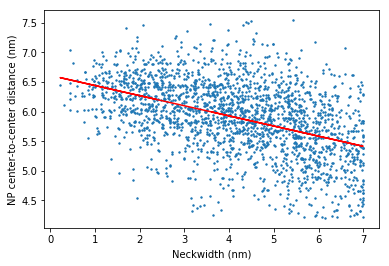

Standard error is: 0.007314
Standard deviation is: 0.338187
Root mean square is: 0.549620
Slope: -0.170988
Intercept: 6.611011
i is: 0
i is: 1
i is: 2
i is: 3
i is: 4
i is: 5
i is: 6
i is: 7
i is: 8
i is: 9
i is: 10
i is: 11
i is: 12
i is: 13
i is: 14
i is: 15
i is: 16
i is: 17
i is: 18
i is: 19
i is: 20
i is: 21
i is: 22
i is: 23
i is: 24
i is: 25
i is: 26
i is: 27
i is: 28
i is: 29
i is: 30
i is: 31
i is: 32
i is: 33
i is: 34
i is: 35
i is: 36
i is: 37
i is: 38
i is: 39
i is: 40
i is: 41
i is: 42
i is: 43
i is: 44
i is: 45
i is: 46
i is: 47
i is: 48
i is: 49
487.02066230773926


In [13]:
parameters = {}
xNum = int(input("Number x nanoparticles: "))
yNum = int(input("Number y nanoparticles: "))
zNum = int(input("Number z nanoparticles: "))
dDiameter = float(input("Desired diameter (nm): "))
dSTD = float(input("Diameter STD (nm): "))
parameters['xNum'] = xNum
parameters['yNum'] = yNum
parameters['zNum'] = zNum
parameters['dDiameter'] = dDiameter
parameters['dSTD'] = dSTD

referenceFrequencyList, neckLinearRegression = createReferenceHistogram()
neckWidthArray = readInNeckWidths()

import time
start = time.time()

for i in range(50):
    print("i is: %i"%i)
    simulatedFrequencyList, edgeList, adjacencyArray = createDistribution(parameters)
    finalList, edgeList, adjacencyArray = simulateAnnealing(referenceFrequencyList, simulatedFrequencyList, edgeList, adjacencyArray, neckWidthArray)

end = time.time()
print(end - start)

Number x nanoparticles: 14
Number y nanoparticles: 6
Number z nanoparticles: 14
Desired diameter (nm): 6.4
Diameter STD (nm): .3


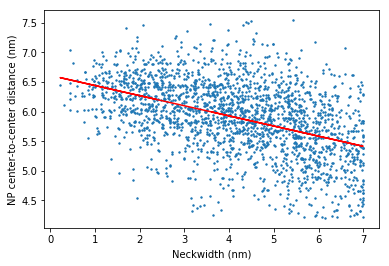

Standard error is: 0.007314
Standard deviation is: 0.338187
Root mean square is: 0.549620
Slope: -0.170988
Intercept: 6.611011
[5, 18, 72, 150, 170, 129, 52]
40295.408881902695


In [19]:
sampleArray = []

#desired parameters
parameters = {}
xNum = int(input("Number x nanoparticles: "))
yNum = int(input("Number y nanoparticles: "))
zNum = int(input("Number z nanoparticles: "))
dDiameter = float(input("Desired diameter (nm): "))
dSTD = float(input("Diameter STD (nm): "))
parameters['xNum'] = xNum
parameters['yNum'] = yNum
parameters['zNum'] = zNum
parameters['dDiameter'] = dDiameter
parameters['dSTD'] = dSTD

import time
start = time.time()
filePath = 'c:/Users/Davis/Research/data/neckedSamples/' + '14x14x6_2nd500grain1/'
if not os.path.exists(filePath):
    os.makedirs(filePath)
    
referenceFrequencyList, neckLinearRegression = createReferenceHistogram()
neckWidthArray = readInNeckWidths()
print(referenceFrequencyList)
for i in range(500):
    simulatedFrequencyList, edgeList, adjacencyArray = createDistribution(parameters)
    finalList, edgeList, adjacencyArray = simulateAnnealing(referenceFrequencyList, simulatedFrequencyList, edgeList, adjacencyArray, neckWidthArray)
    print(finalList)
    
    sample = triclinic_lattice(parameters, edgeList, neckLinearRegression)
    np_array, np_array_flipped, cellsize_array = sample.returnLattice()
    sampleArray.append([np_array, cellsize_array])
    sampleArray.append([np_array_flipped, cellsize_array])
    
    filename = "neckSample" + str(i) + ".inp"
    fullpath = os.path.join(filePath, filename)
    with open(fullpath,'w+') as f:
        f.write("id1 id2 type necking_width\n")

        for j in range(0,len(edgeList)):
            id1 = edgeList[j][0][0]
            id2 = edgeList[j][0][1]
            thistype = 1
            neckWidth = edgeList[j][1]
            
            if neckWidth > 0:
                f.write(str(id1) + " " + str(id2) + " " + str(thistype) + " " + str(neckWidth) + "\n")
            
end = time.time()
print(end - start)

filePath = 'c:/Users/Davis/Research/data/neckedSamples/' + '14x14x6_2nd500grain1/'
if not os.path.exists(filePath):
    os.makedirs(filePath)
    
for i in range(0,len(sampleArray)):
    
    filename = "npSample" + str(i) + ".inp"
    fullpath = os.path.join(filePath, filename)
    np_array = sampleArray[i][0]
    cellsize_array = sampleArray[i][1]

    with open(fullpath,'w+') as f:
        f.write("cell(1), %f\n" %cellsize_array[0])#X  center-center distance leftmost-rightmost + desired diameter
        f.write("cell(2), %f\n" %cellsize_array[1])#Y  Defines height (layers)
        f.write("cell(3), %f\n" %cellsize_array[2])#Z  Transport direction
        f.write("id type layer x y z diameter\n")

        for j in range(0,len(np_array)):
            np_id = str(j)
            np_type = "1"
            np_layer = "1"
            
            x = str(np_array[j][0])
            y = str(np_array[j][1])
            z = str(np_array[j][2])
            d = str(np_array[j][3])
            f.write(np_id + " " + np_type + " " + np_layer + " " + x + " " + y + " " + z + " " + d + "\n")

In [9]:
def crossGrain(id1, id2, zNum):
        return (id1%zNum == zNum/2 - 1 and id2%zNum == zNum/2) or (id2%zNum == zNum/2 - 1 and id1%zNum == zNum/2)

def removeGrainNecks(edgeList, zNum):
    
    #assume remove necks along middle of sample
    newList = [i for i in edgeList if not crossGrain(i[0][0],i[0][1],zNum)]
    return newList

Number x nanoparticles: 14
Number y nanoparticles: 6
Number z nanoparticles: 14
Desired diameter (nm): 6.4
Diameter STD (nm): .3


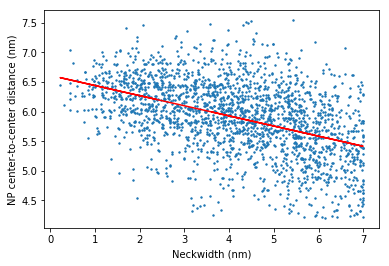

Standard error is: 0.007314
Standard deviation is: 0.338187
Root mean square is: 0.549620
Slope: -0.170988
Intercept: 6.611011


In [11]:
sampleArray = []

#desired parameters
parameters = {}
xNum = int(input("Number x nanoparticles: "))
yNum = int(input("Number y nanoparticles: "))
zNum = int(input("Number z nanoparticles: "))
dDiameter = float(input("Desired diameter (nm): "))
dSTD = float(input("Diameter STD (nm): "))
parameters['xNum'] = xNum
parameters['yNum'] = yNum
parameters['zNum'] = zNum
parameters['dDiameter'] = dDiameter
parameters['dSTD'] = dSTD

referenceFrequencyList, neckLinearRegression = createReferenceHistogram()

readFilePath = 'c:/Users/Davis/Research/data/neckedSamples/' + '14x14x6/'
writeFilePath = 'c:/Users/Davis/Research/data/neckedSamples/' + '14x14x6withGrains/'
if not os.path.exists(writeFilePath):
    os.makedirs(writeFilePath)

for i in range(500):
    filename = "neckSample" + str(i) + '.inp'
    readfullpath = os.path.join(readFilePath, filename)
    writefullpath = os.path.join(writeFilePath, filename)
    f = open(readfullpath,'r')
    index = 0
    edgeList = []
    with open(writefullpath,'w+') as g:
        for line in f:
            if index > 0:
                newline = line.split()
                id1 = int(newline[0])
                id2 = int(newline[1])
                neckWidth = float(newline[3])
                edgeList.append([[id1,id2],neckWidth])
            else:
                g.write(line)
            index += 1
        f.close()
        
        newEdgeList = removeGrainNecks(edgeList,zNum)
        for i in newEdgeList:
            g.write(str(i[0][0]) + " " + str(i[0][1]) + " " + "1 " + str(i[1]) + "\n")
            
    sample = triclinic_lattice(parameters, newEdgeList, neckLinearRegression)
    np_array, np_array_flipped, cellsize_array = sample.returnLattice()
    sampleArray.append([np_array, cellsize_array])
    sampleArray.append([np_array_flipped, cellsize_array])
        
        
for i in range(0,len(sampleArray)):
    
    filename = "npSample" + str(i) + ".inp"
    fullpath = os.path.join(writeFilePath, filename)
    np_array = sampleArray[i][0]
    cellsize_array = sampleArray[i][1]

    with open(fullpath,'w+') as f:
        f.write("cell(1), %f\n" %cellsize_array[0])#X  center-center distance leftmost-rightmost + desired diameter
        f.write("cell(2), %f\n" %cellsize_array[1])#Y  Defines height (layers)
        f.write("cell(3), %f\n" %cellsize_array[2])#Z  Transport direction
        f.write("id type layer x y z diameter\n")

        for j in range(0,len(np_array)):
            np_id = str(j)
            np_type = "1"
            np_layer = "1"
            
            x = str(np_array[j][0])
            y = str(np_array[j][1])
            z = str(np_array[j][2])
            d = str(np_array[j][3])
            f.write(np_id + " " + np_type + " " + np_layer + " " + x + " " + y + " " + z + " " + d + "\n")

Number x nanoparticles: 14
Number y nanoparticles: 6
Number z nanoparticles: 14
Desired diameter (nm): 6.4
Diameter STD (nm): .3


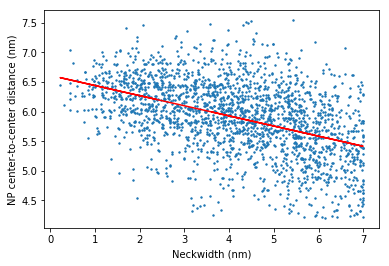

Standard error is: 0.007314
Standard deviation is: 0.338187
Root mean square is: 0.549620
Slope: -0.170988
Intercept: 6.611011


In [9]:
sampleArray = []

#desired parameters
parameters = {}
xNum = int(input("Number x nanoparticles: "))
yNum = int(input("Number y nanoparticles: "))
zNum = int(input("Number z nanoparticles: "))
dDiameter = float(input("Desired diameter (nm): "))
dSTD = float(input("Diameter STD (nm): "))
parameters['xNum'] = xNum
parameters['yNum'] = yNum
parameters['zNum'] = zNum
parameters['dDiameter'] = dDiameter
parameters['dSTD'] = dSTD

filePath = 'c:/Users/Davis/Research/data/neckedSamples/' + '14x14x6/'
referenceFrequencyList, neckLinearRegression = createReferenceHistogram()
for i in range(500):
    filename = "neckSample" + str(i) + ".inp"
    fullpath = os.path.join(filePath, filename)
    f = open(fullpath, 'r')
    index = 0
    edgeList = []
    for line in f:
        if index > 0:
            newline = line.split()
            id1 = int(newline[0])
            id2 = int(newline[1])
            neckWidth = float(newline[3])
            edgeList.append([[id1,id2],neckWidth])
        index += 1
    f.close()
    sample = triclinic_lattice(parameters, edgeList, neckLinearRegression)
    np_array, np_array_flipped, cellsize_array = sample.returnLattice()
    sampleArray.append([np_array, cellsize_array])
    sampleArray.append([np_array_flipped, cellsize_array])
    #print("Finished Sample %i"%i)
    
for i in range(0,len(sampleArray)):
    
    filename = "npSample" + str(i) + ".inp"
    fullpath = os.path.join(filePath, filename)
    np_array = sampleArray[i][0]
    cellsize_array = sampleArray[i][1]

    with open(fullpath,'w+') as f:
        f.write("cell(1), %f\n" %cellsize_array[0])#X  center-center distance leftmost-rightmost + desired diameter
        f.write("cell(2), %f\n" %cellsize_array[1])#Y  Defines height (layers)
        f.write("cell(3), %f\n" %cellsize_array[2])#Z  Transport direction
        f.write("id type layer x y z diameter\n")

        for j in range(0,len(np_array)):
            np_id = str(j)
            np_type = "1"
            np_layer = "1"
            
            x = str(np_array[j][0])
            y = str(np_array[j][1])
            z = str(np_array[j][2])
            d = str(np_array[j][3])
            f.write(np_id + " " + np_type + " " + np_layer + " " + x + " " + y + " " + z + " " + d + "\n")